<a href="https://colab.research.google.com/github/MyNameIsEldar/Movie_Recommender/blob/main/rec_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Импорты

In [1]:
import numpy as np

import pandas as pd
import os
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error, roc_auc_score, f1_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

### Получение и обработка данных

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest.zip
!unzip ml-latest.zip

In [4]:
PATH = 'ml-latest/'

In [5]:
ratings = pd.read_csv(PATH+'ratings.csv')
genome_scores = pd.read_csv(PATH+'genome-scores.csv')
genome_tags = pd.read_csv(PATH+'genome-tags.csv')
links = pd.read_csv(PATH+'links.csv')
movies = pd.read_csv(PATH+'movies.csv')
tags = pd.read_csv(PATH+'tags.csv')

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


27M слишком большой датасет поэтому будем использовать только 10 %

In [8]:
rand_userIds = np.random.choice(ratings['userId'].unique(), 
                                size=int(len(ratings['userId'].unique())*0.10), 
                                replace=False)

ratings = ratings.loc[ratings['userId'].isin(rand_userIds)]

print('There are {} rows of data from {} users'.format(len(ratings), len(rand_userIds)))

There are 2777580 rows of data from 28322 users


* tag.csv : данные пользователей о тегах к фильмах
* rating.csv : оценки фильмов от пользователей в основном будем юзать их
* movie.csv : инфа о фильмах
* link.csv : ссылки на площадки и другие ресурсы
* genome_scores.csv : id фильмов id тегов и актуальность 
* genome_tags.csv : описание тегов



In [9]:
ratings.rating.value_counts()

rating
4.0    743165
3.0    550831
5.0    407015
3.5    340890
4.5    239031
2.0    183500
2.5    136329
1.0     88326
0.5     44628
1.5     43865
Name: count, dtype: int64

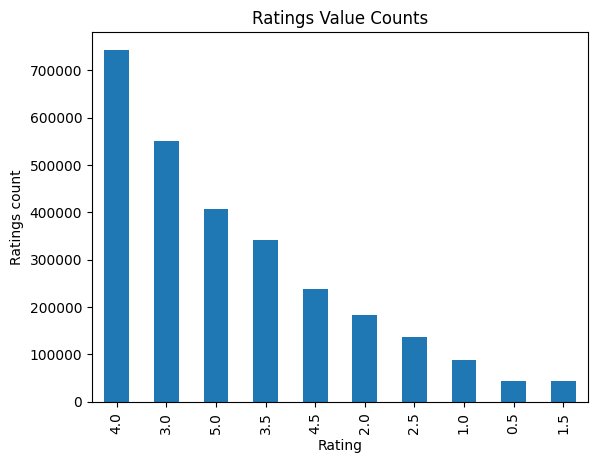

In [10]:
ratings.rating.value_counts().plot(kind='bar')
plt.title('Ratings Value Counts')
plt.ylabel('Ratings count')
plt.xlabel('Rating')
plt.show()

In [11]:
print(f'There are {ratings.movieId.nunique()} unique films in data')

There are 28920 unique films in data


In [12]:
print(f'There are {ratings.userId.nunique()} unique users in data')

There are 28322 unique users in data


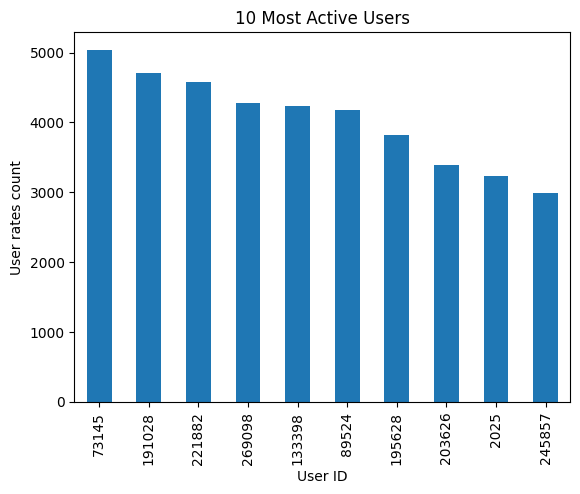

In [13]:
ratings.userId.value_counts()[:10].plot(kind='bar')
plt.title('10 Most Active Users')
plt.ylabel('User rates count')
plt.xlabel('User ID')
plt.show()

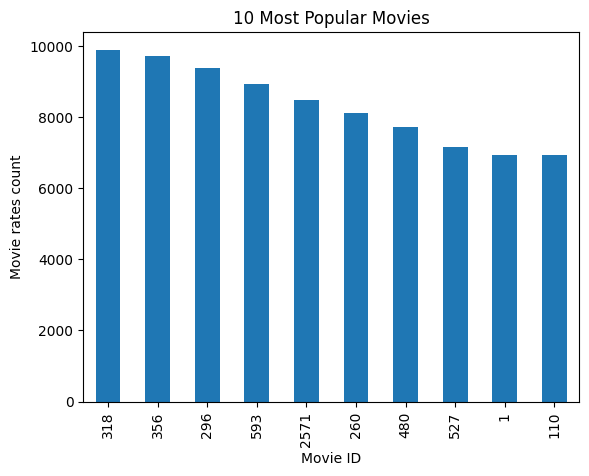

In [14]:
ratings.movieId.value_counts()[:10].plot(kind='bar')
plt.title('10 Most Popular Movies')
plt.ylabel('Movie rates count')
plt.xlabel('Movie ID')
plt.show()

In [15]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2777580 entries, 1854 to 27750012
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 106.0 MB


In [16]:
# change dtype for timestamp
# ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s', origin='unix')
# ratings.head()

Поиск отсутствующих данных

In [17]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Поиск дублирующихся данных

In [18]:
ratings.duplicated().sum()

0

### Подготовка данных

### Разбиение датасета 

Наряду с рейтингом есть также столбец с отметкой времени, в котором указаны дата и время отправки обзора. Используя столбец метки времени, мы реализуем нашу стратегию разделения обучения и тестирования. Для каждого пользователя самый последний отзыв используется в качестве тестового набора, а остальные будут использоваться в качестве обучающих данных.

Эта стратегия разделения обучения и тестирования часто используется при обучении и оценке рекомендательных систем. Выполнение случайного разделения было бы нечестным, поскольку мы потенциально могли бы использовать недавние отзывы пользователя для обучения и более ранние отзывы для тестирования. Это приводит к утечке данных с предвзятостью, и производительность обученной модели нельзя обобщить на реальную производительность.

Приведенный ниже код разделит наш набор данных рейтингов на обучающий и тестовый наборы.

In [19]:
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)

train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

ratings.head(10)

,userId,movieId,rating,timestamp,rank_latest
1854,21,249,3.0,1238034395,13.0
1855,21,599,4.5,1238034497,2.0
1856,21,922,4.0,1238034378,14.0
1857,21,930,3.5,1238034413,11.0
1858,21,1237,4.5,1238034466,5.0
1859,21,2053,1.0,1238034431,9.0
1860,21,2082,2.5,1238034437,8.0
1861,21,3730,5.0,1238034480,3.0
1862,21,3798,2.5,1238034377,15.0
1863,21,3981,2.0,1238034476,4.0


In [20]:
train_ratings.head()

,userId,movieId,rating,timestamp,rank_latest
1854,21,249,3.0,1238034395,13.0
1855,21,599,4.5,1238034497,2.0
1856,21,922,4.0,1238034378,14.0
1857,21,930,3.5,1238034413,11.0
1858,21,1237,4.5,1238034466,5.0


In [21]:
test_ratings.head()

,userId,movieId,rating,timestamp,rank_latest
1867,21,46530,3.5,1238034517,1.0
4588,55,2090,3.0,1059058108,1.0
7177,76,3979,3.5,1450462960,1.0
8765,82,1198,4.0,1456498808,1.0
11768,126,2248,3.0,1294552844,1.0


In [22]:
# Избавляемся от лишних данных
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

Теперь у нас есть разделенные датасеты и можно приступать к оценке модели

Наша задача - предсказать, будет ли пользователь смотреть этот фильм или нет. Поэтому нам нужно изменить целевые значения. Теперь у нас есть только рейтинги (числа от 1 до 5), но нам нужно знать смотрел ли пользователь фильм или нет. Будем считать что если человек смотрел фильм то ставим 1

In [23]:
train_ratings['target'] = 1
train_ratings.head()

,userId,movieId,rating,target
1854,21,249,3.0,1
1855,21,599,4.5,1
1856,21,922,4.0,1
1857,21,930,3.5,1
1858,21,1237,4.5,1


In [24]:
#получеаем весь список айдишников фильмо
all_movieIds = ratings['movieId'].unique()

# здесь будут данные для обучения
users, items, labels = [], [], []

# набор данных с которыми взаимодействуют пользователь
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

In [25]:
class MovieLensDataset(Dataset):
   
    def __init__(self, ratings, all_movieIds, train=True):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds, train)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds, train):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        num_negatives = 2
        for u, i in tqdm(user_item_set):
            users.append(u)
            items.append(i)
            labels.append(1)
            if train:
              for _ in range(num_negatives):
                  negative_item = np.random.choice(all_movieIds)
                  while (u, negative_item) in user_item_set:
                      negative_item = np.random.choice(all_movieIds)
                  users.append(u)
                  items.append(negative_item)
                  labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

In [26]:
train_dataset = MovieLensDataset(train_ratings, all_movieIds)
train_dataset

  0%|          | 0/2749258 [00:00<?, ?it/s]

In [27]:
test_dataset = MovieLensDataset(test_ratings, all_movieIds, train=False)
test_dataset

  0%|          | 0/28322 [00:00<?, ?it/s]

In [28]:
train_dataloader = DataLoader(train_dataset, batch_size=2048, shuffle=False,
                                  num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=2048, shuffle=False,
                                  num_workers=1)

### Модель

### Learned Embeddings

Мы будем использовать отдельный слой встраивания элементов для представления характеристик элементов (например, фильмов) в пространстве более низкого измерения.

С помощью Neural Collaborative Filtering мы можем узнать веса встраиваемого слоя, чтобы он обеспечивал точное представление пользователей и элементов. Используя набор данных рейтингов, мы можем идентифицировать похожих пользователей и фильмы, создавая встраивания пользователей и элементов, извлеченные из существующих рейтингов.


### Архитектуа модели

Встроенные векторы пользователей и элементов объединяются перед прохождением через серию полноcвязнных слоев, которые отображают конкатенированные embedding слои в вектор предсказания в качестве выходных данных. Наконец, мы применяем функцию «сигмоид», чтобы получить наиболее вероятный класс.

In [29]:
class NCF(nn.Module):
    
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds
        
    def forward(self, user_input, item_input):
    
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # объеденияем слои
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, predicted_labels, labels):
        predicted_labels = predicted_labels
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

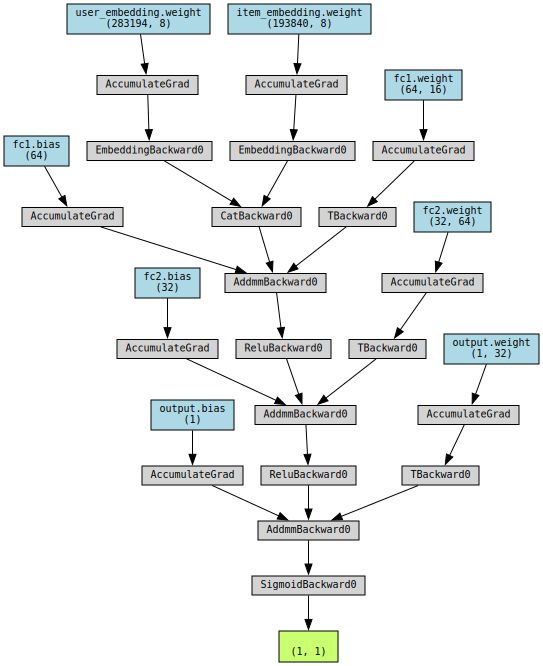

In [37]:
from torchviz import make_dot

model = NCF(num_users, num_items, ratings, all_movieIds)
x = (torch.zeros(1, dtype=torch.long), torch.zeros(1, dtype=torch.long))
make_dot(model(*x), params=dict(model.named_parameters()))

In [32]:
def train_nn(net, num_epochs, train, test, metric=f1_score):
  f1_vals = []
  epochs = []
  optimizer = net.configure_optimizers()

  for epoch in tqdm(range(num_epochs)):

    for batch in tqdm(train):
        users_train, movies_train, labels_train = batch
        optimizer.zero_grad()

        preds = net.forward(users_train, movies_train)

        loss_value = net.training_step(preds, labels_train)
        loss_value.backward()
        optimizer.step()

    if epoch % 1 == 0:
        predicted_films = []
        all_test_labels = [] 
        with torch.no_grad():
            net.eval()
            for batch in test:
                users_test, movies_test, labels_test = batch

                test_preds = net.forward(users_test, movies_test)
                
                predicted_films.append(test_preds)
                all_test_labels.append(labels_test)

        all_test_labels = torch.cat(all_test_labels).detach().numpy()
        predicted_films = torch.cat(predicted_films).round().detach().numpy()
        F1 = metric(all_test_labels, predicted_films)
        print(f"epoch:{epoch}, F1 test: {F1}")


In [33]:
num_users = ratings['userId'].max()+1
num_items = ratings['movieId'].max()+1

all_movieIds = ratings['movieId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

In [34]:
emb = nn.Embedding(num_embeddings=num_users, embedding_dim=4)
emb_t = emb(torch.tensor(users).to(torch.int64))
emb_t

tensor([], size=(0, 4), grad_fn=<EmbeddingBackward0>)

In [35]:
emb_t.shape

torch.Size([0, 4])

In [36]:
train_nn(model, 1, train_dataloader, test_dataloader)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4028 [00:00<?, ?it/s]

epoch:0, F1 test: 0.9070350789179176


### Оценка модели

Теперь, когда наша модель обучена, мы готовы оценить ее, используя тестовые данные. В традиционных проектах машинного обучения мы оцениваем наши модели с использованием таких показателей, как точность (для задач классификации) и RMSE (для задач регрессии). Однако такие показатели слишком упрощены для оценки рекомендательных систем.

Ключевым моментом здесь является то, что нам не нужно, чтобы пользователь взаимодействовал с каждым отдельным элементом в списке рекомендаций. Вместо этого нам просто нужно, чтобы пользователь взаимодействовал хотя бы с одним элементом в списке — до тех пор, пока пользователь делает это,
рекомендации сработали.

Чтобы имитировать это, сделаем следующее
* Для каждого пользователя случайным образом берем 99 элементов, с которыми пользователь не взаимодействовал
* Объединяем эти 99 элементов с тестовым элементом (фактический элемент, с которым взаимодействовал пользователь). Теперь у нас есть 100 предметов.
* Запускаем модель на этих 100 элементах и сортируем их в соответствии с их предсказанными вероятностями.
* берем 10 лучших элементов из списка 100 элементов.
Если тестовый элемент присутствует в топ-10, то мы говорим, что это попадание.
* Повторяем для все х пользователей. Коэффициент попаданий — это среднее количество попаданий.

Этот протокол оценки известен как Hit Ratio @ 10 и обычно используется для оценки рекомендательных систем.

In [38]:
# пары пользователь элемент для теста
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))
user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
top10_items        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

  0%|          | 0/28322 [00:00<?, ?it/s]

The Hit Ratio @ 10 is 0.10


In [40]:
top10_items

[76832, 60471, 50615, 7944, 7160, 128914, 414, 147234, 169778, 63629]